<a href="https://colab.research.google.com/github/Sreehithareddy31/NewsTopics/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install torch
!pip install accelerate -U
!pip install --upgrade transformers

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px

In [ ]:
df=pd.read_csv("/content/bbc-text.csv")
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [ ]:
print(df.head())
print(df.info())
print(df['category'].value_counts())

        category                                               text
0           tech  tv future in the hands of viewers with home th...
1       business  worldcom boss  left books alone  former worldc...
2          sport  tigers wary of farrell  gamble  leicester say ...
3          sport  yeading face newcastle in fa cup premiership s...
4  entertainment  ocean s twelve raids box office ocean s twelve...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB
None
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


In [ ]:
df.shape

(2225, 2)

In [ ]:
print(df.isnull().sum())

category    0
text        0
dtype: int64


In [ ]:
df.describe()

,category,text
count,2225,2225
unique,5,2126
top,sport,blind student hears in colour a blind studen...
freq,511,2


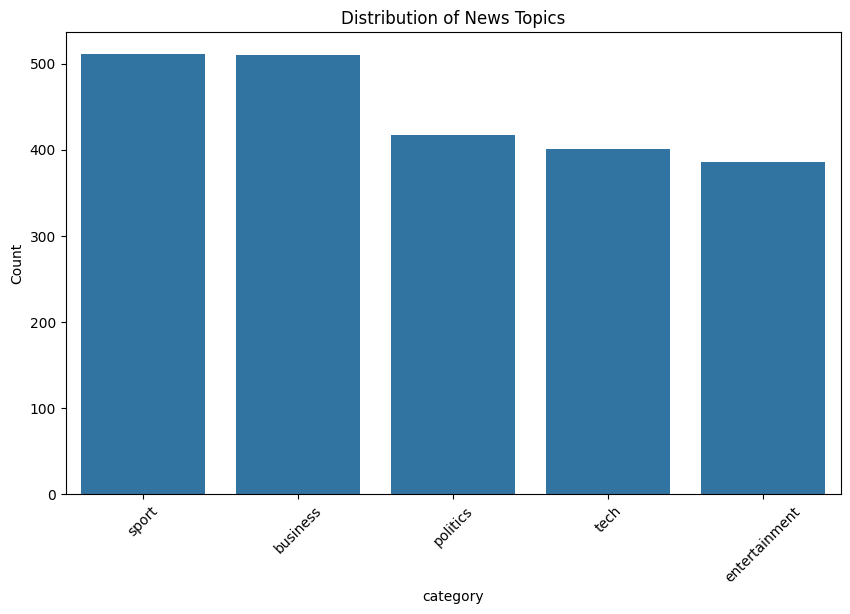

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='category', order=df['category'].value_counts().index)
plt.title('Distribution of News Topics')
plt.xlabel('category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


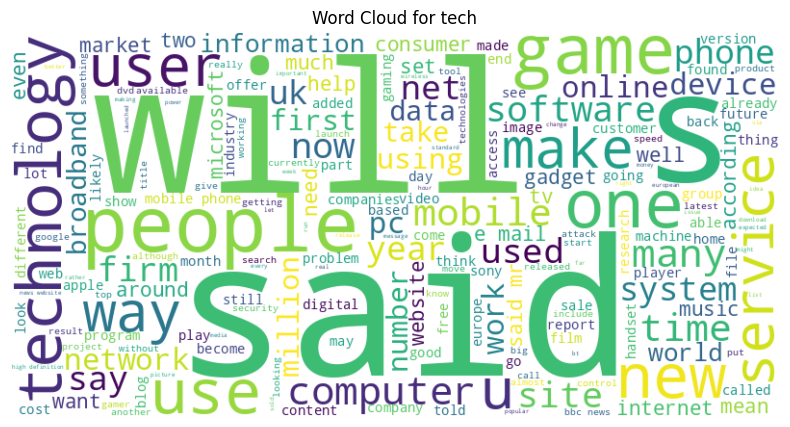

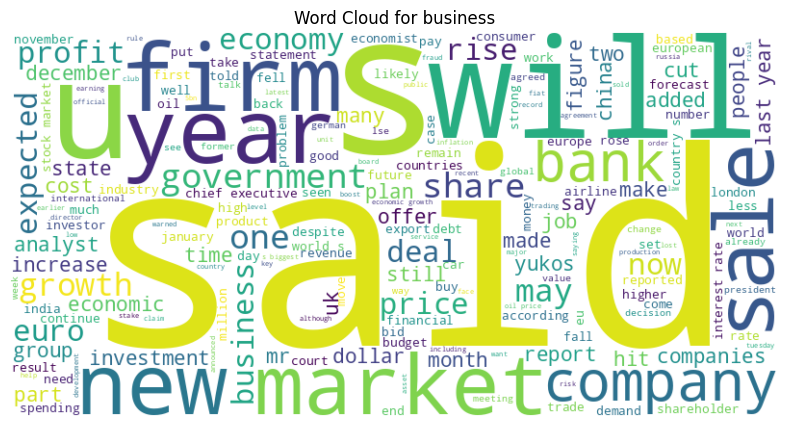

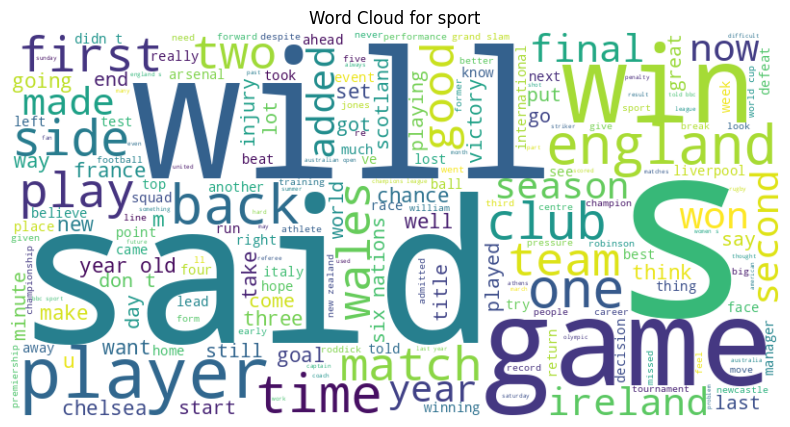

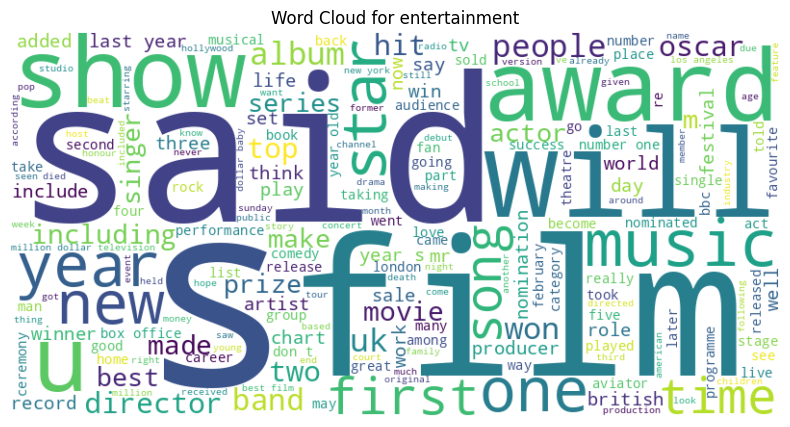

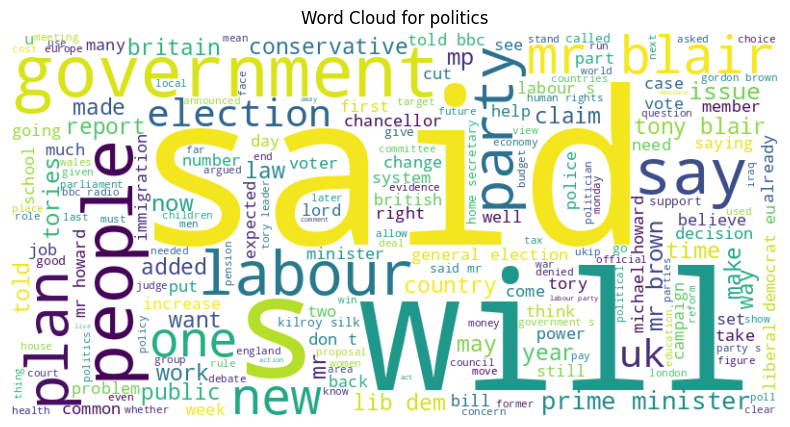

In [ ]:
topics = df['category'].unique()

for topic in topics:
    text = ' '.join(df[df['category'] == topic]['text'].values)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {topic}')
    plt.show()


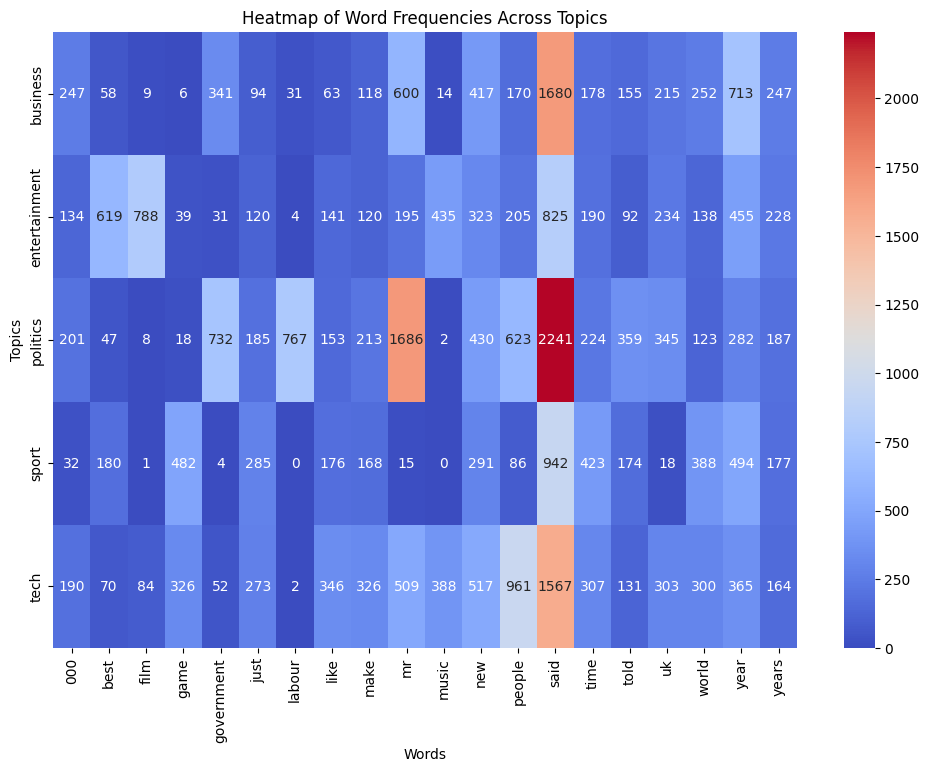

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=20, stop_words='english')
X = vectorizer.fit_transform(df['text'])
words = vectorizer.get_feature_names_out()

word_freq = pd.DataFrame(X.toarray(), columns=words)
word_freq['category'] = df['category']

topic_word_freq = word_freq.groupby('category').sum()

plt.figure(figsize=(12, 8))
sns.heatmap(topic_word_freq, annot=True, cmap='coolwarm', fmt='d')
plt.title('Heatmap of Word Frequencies Across Topics')
plt.xlabel('Words')
plt.ylabel('Topics')
plt.show()


In [ ]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['category'])

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42)

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 require

In [ ]:
from datasets import Dataset

In [ ]:
train_df = pd.DataFrame({'text': train_texts, 'label': train_labels})
test_df = pd.DataFrame({'text': test_texts, 'label': test_labels})

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
import torch
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.Tensor(logits), dim=-1)  # Convert logits to a PyTorch tensor
    return {'accuracy': accuracy_score(labels, predictions)}

In [ ]:
!pip install accelerate -U

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',  # Changed from evaluation_strategy to eval_strategy
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

In [ ]:
results = trainer.evaluate()
print(f"Test Accuracy: {results['eval_accuracy'] * 100:.2f}%")

In [ ]:
model.save_pretrained('bbc_news_classification_model')
tokenizer.save_pretrained('bbc_news_classification_model')